In [246]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from lib.SamplingOptimizer import SamplingOptimizer
from lib.RangeOptimizer import RangeOptimizer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
# x1 ∈ [-5, 10], x2 ∈ [0, 15]
def brannin_hoo(x, e_std=0.01):
    a = 1
    b = 5.1 / (4 * np.pi ** 2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    e = np.random.normal(0, e_std)
        
    return (x[1] - b * x[0] ** 2 + c * x[0] - r) ** 2 + s * (1 - t) * np.cos(x[0]) + s + e

brannin_hoo(np.array([9.424,2.475]), e_std=0.1)

0.33882199254423584

1.93491482488


/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


0.418871538307
0.408040792062
3.01001788843
1.7376580571
1.08293149188
0.48804903533
13.5593979632
0.442266942571
0.438747781662
0.513588337685
2.56020820043


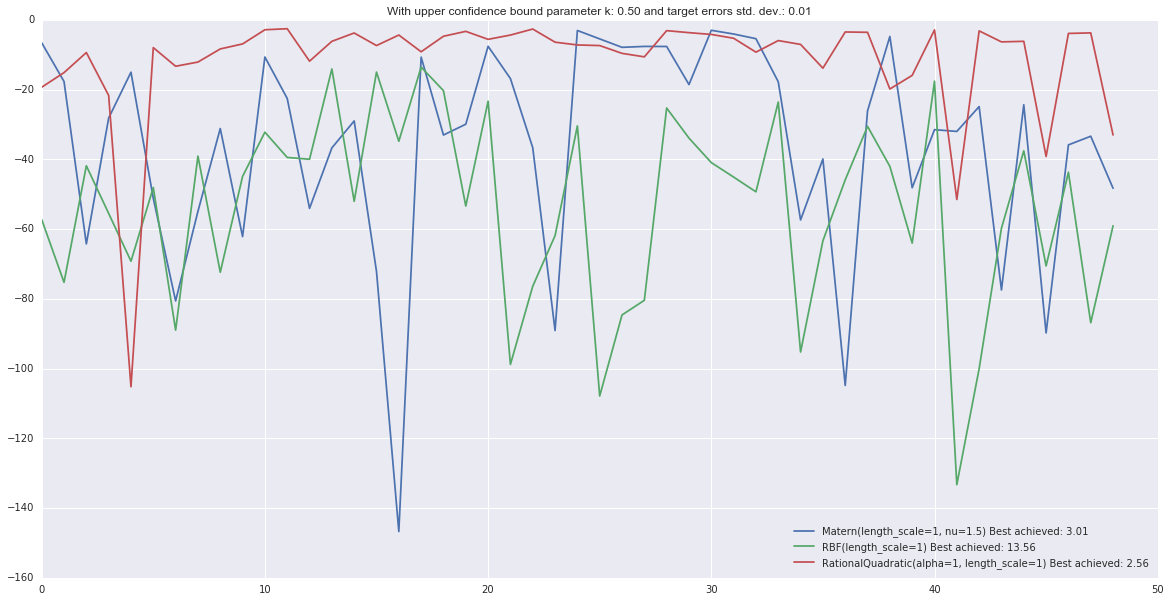

0.344447366856
0.326598634871
0.512885443036
3.42518380346
1.04543101041
1.02549912635
0.470584510114
5.52678143852
0.804427262411
0.434462094083
0.396433406414
1.24997586047


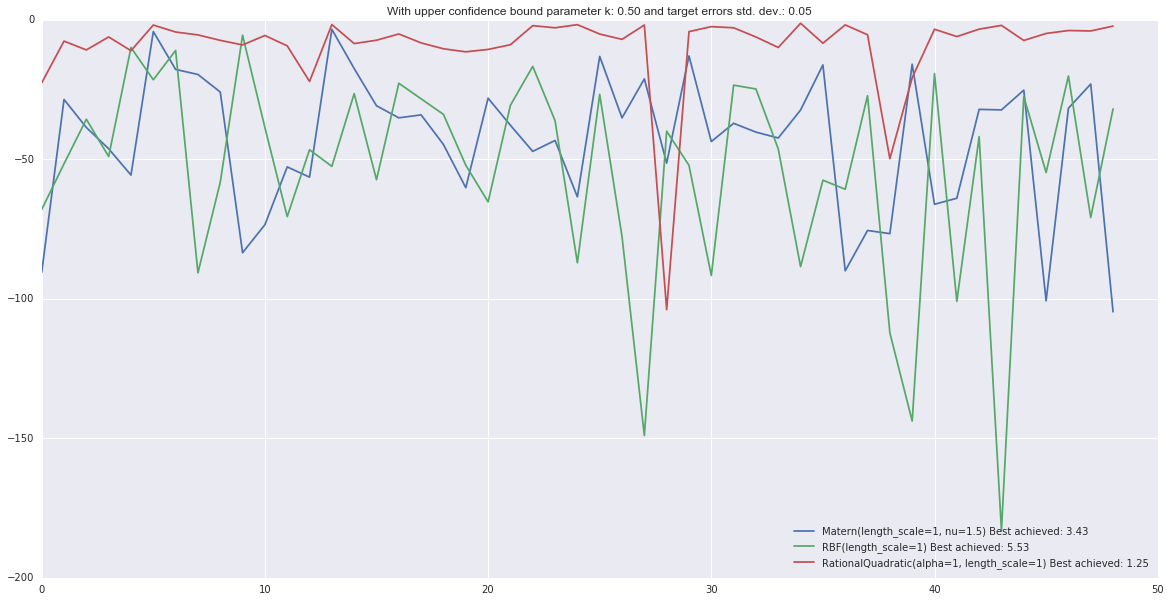

0.589283891458
0.494081317039
0.496823485345
0.900382734965
1.2318868103
0.415533740446
1.58774965193
9.46509564701
1.64671453491
0.598204710655
0.5495886256
3.8856975925


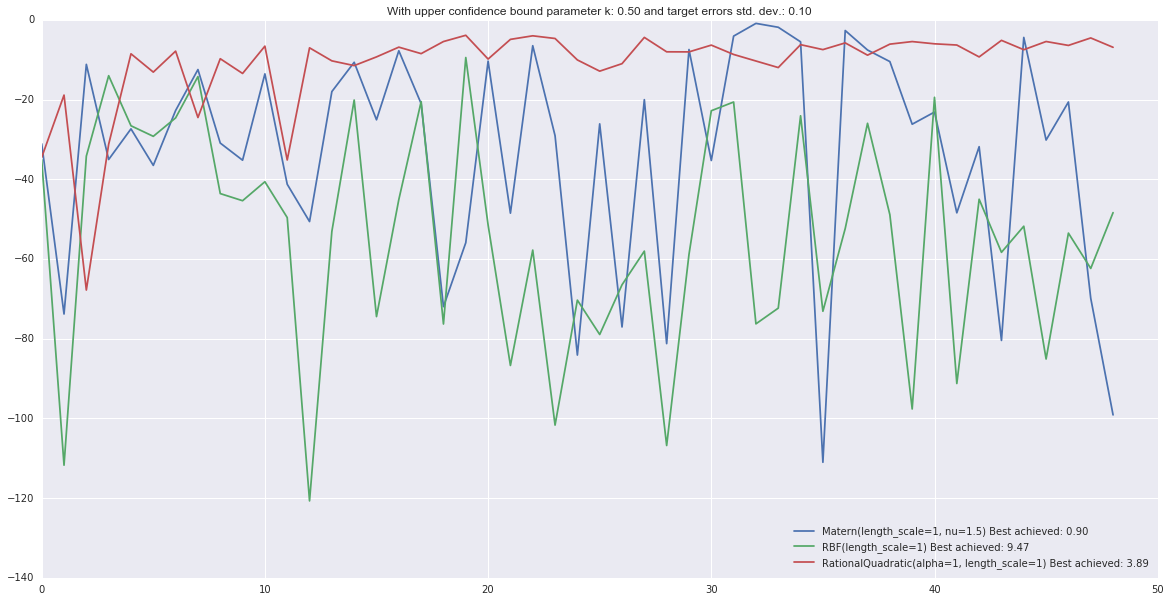

0.478876855039
0.369136360104
0.393963593339
0.468442739926
0.530072583765
2.12741622237
0.975603257038
6.6868054847
0.643579489957
0.670298180602
1.28955147726
4.31939541799


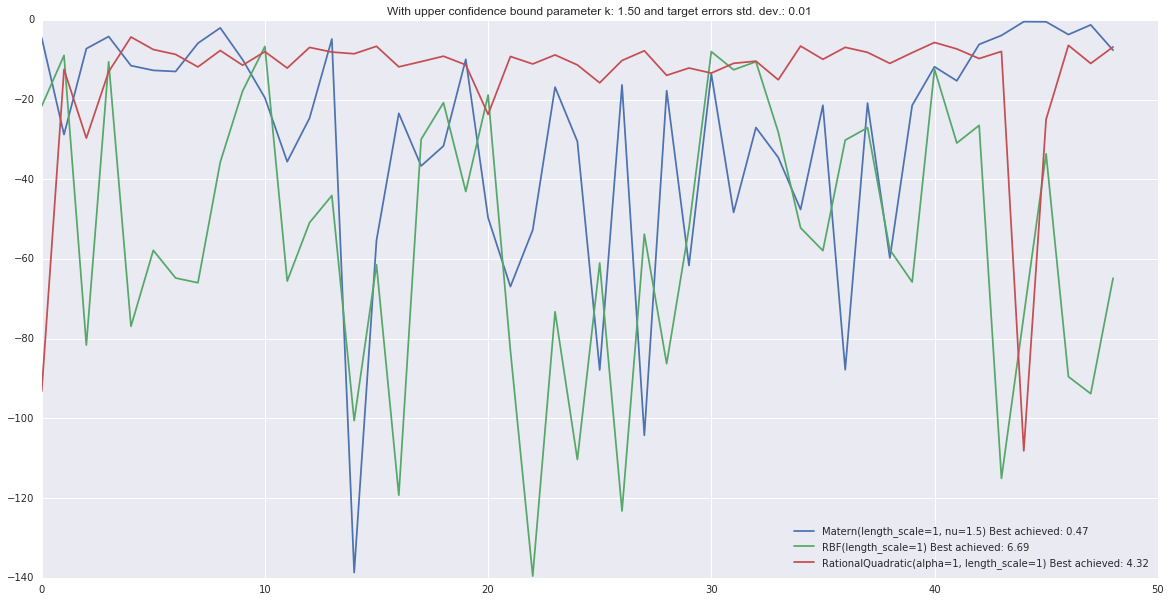

2.04992022076
0.394346605804
0.388535285898
3.83108583514
0.508744646922
0.611487557495
0.602101145646
7.0139612199
2.79251753841
0.516529675541
0.557797566989
3.40433056787


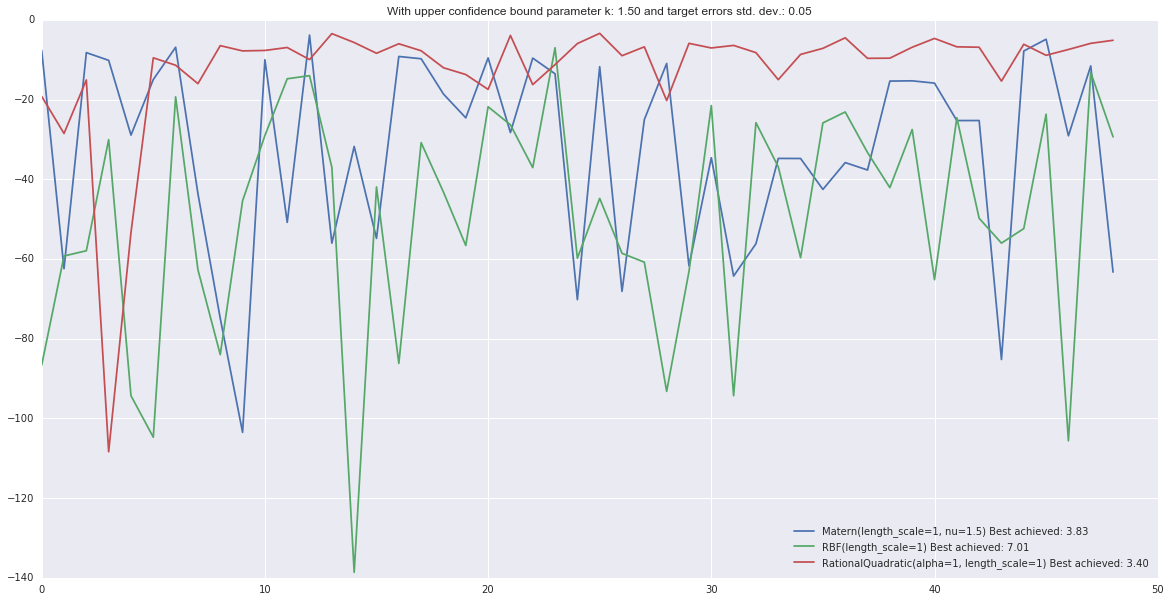

0.258589159681
0.304540267466
0.341431776006
1.02395417094
0.977724986009
0.476222668821
1.23464670374
2.17473263477


/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'grad': array([ 328.54774722, -375.40866886]), 'warnflag': 2, 'nit': 6}
  " state: %s" % convergence_dict)


0.754595541198
0.666176518542
0.674674679123
0.768650148842


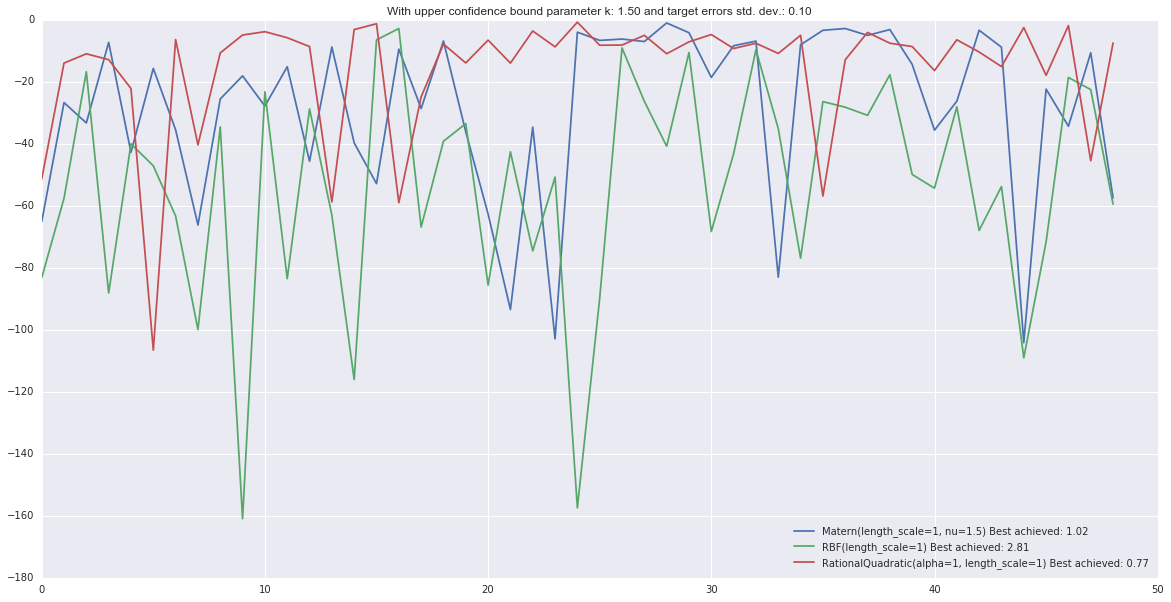

0.944179400874
0.403412239341
1.58635144126
7.78037951556
1.49590118244
1.26581450689
0.928391966917
10.7174879308
0.920018211922
0.837419130213
0.493134157284
2.51688799264


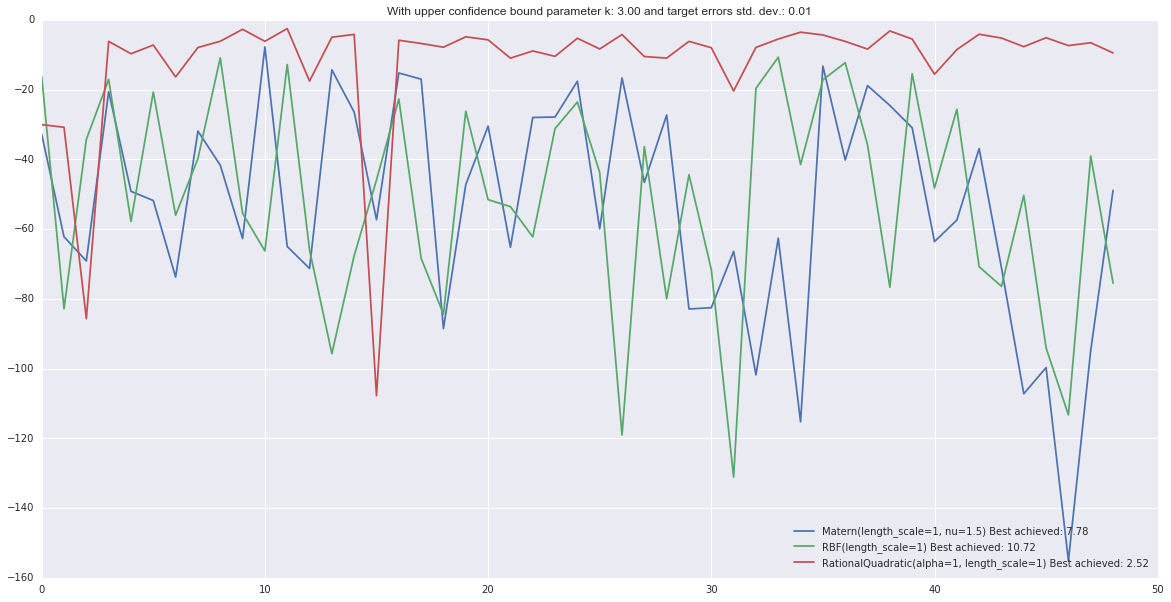

0.569835137831
2.06369792032
0.372860066154
3.19876030868
0.95399888535
1.66486616139
3.08226962269
8.68099788987
0.562337973368
0.451061600562
0.4128911107
0.774441042822


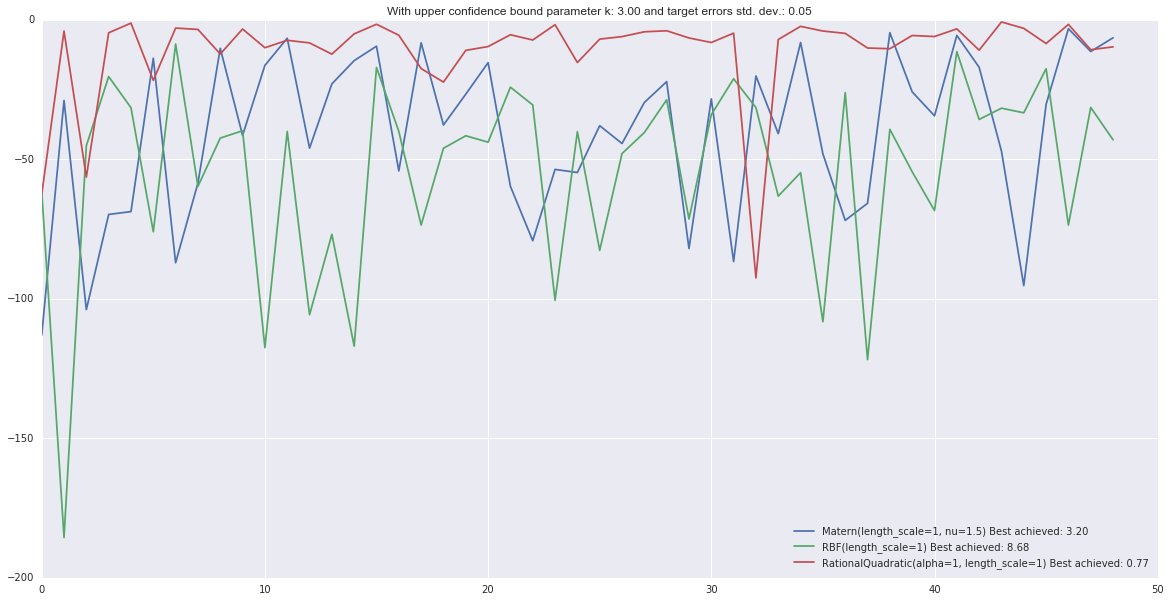

0.435863526875
0.291741450095
0.313252950599
0.52684905477
2.43040151224
1.27009544247
0.634748231823
4.81914689486
0.29948600802
0.334098245348
0.540119054379
1.47755887348


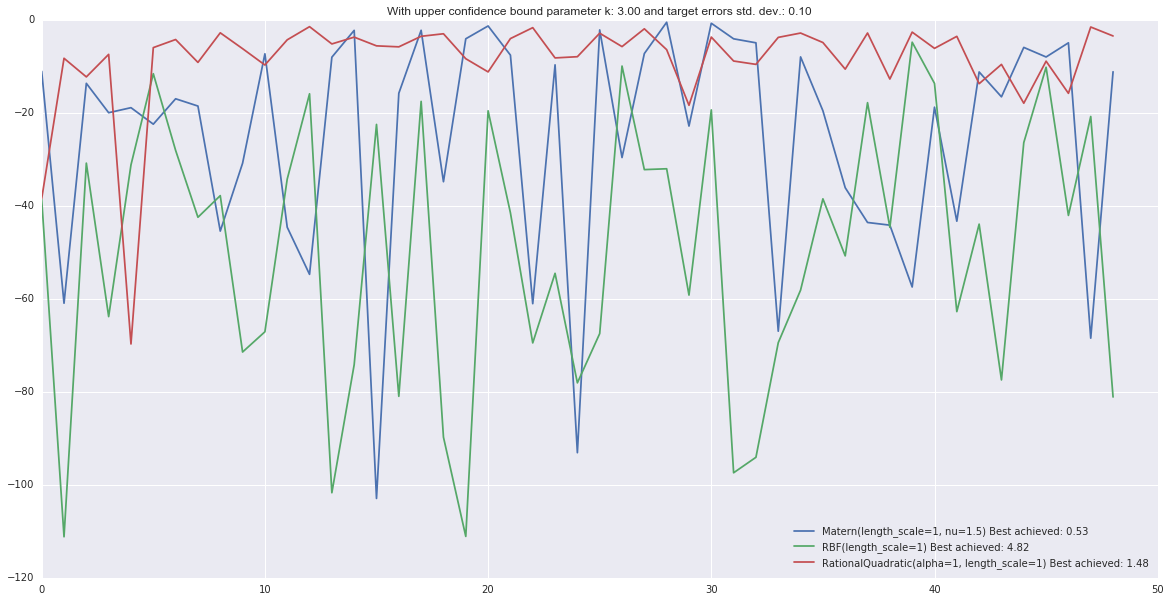

In [274]:
for k in [.5, 1.5, 3]:
    for e in [.01, 0.05, .1]:
        results = []
        for i, kernel in enumerate([Matern(), RBF(), RationalQuadratic()]):
            ro = RangeOptimizer({
                'x1': (-5., 10.),
                'x2': (0., 15.)
            }, kernel=kernel, init_observations=[
                [1, 2, brannin_hoo(np.array([1, 2]), e_std=0.1)],
                [1, 2, brannin_hoo(np.array([0, 0]), e_std=0.1)]
            ], acquisition_params={
                'k': k,
                'type': 'upper_confidence_bound'
            })
            all_scores = []
            for r in range(3):
                run_scores = []
                for t in range(50):
                    x = ro.suggest(return_dict=True)
                    y = - brannin_hoo([x['x1'], x['x2']], e_std=e) # negative to turn mimization into maximization
                    run_scores.append(y)
                    ro.update([x[fn] for fn in ro.feature_names], y)
                    
                print(-np.max(run_scores))
                all_scores.append(run_scores)
                
            avg_scores = np.stack(all_scores, axis=1).mean(axis=1)
            print(-np.max(avg_scores))
            results.append((avg_scores,str(kernel)))

        plt.figure(figsize=(20,10))
        for i, r in enumerate(results):
            plt.plot(r[0][1:], label='{} Best achieved: {:.2f}'.format(r[1], -np.max(r[0][1:])))

        plt.title('With upper confidence bound parameter k: {:.2f} and target errors std. dev.: {:.2f}'.format(k, e))
        plt.legend(loc=4)
        plt.show()

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


1.56950454853


/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'grad': array([-7422.03125]), 'warnflag': 2, 'nit': 0}
  " state: %s" % convergence_dict)


0.747042964415
2.21460329083
4.90601646254
1.58839792371
0.486064021426
1.08427515317
2.35301324287
0.927803294623
0.643944628634
0.443796672788
1.11925976336


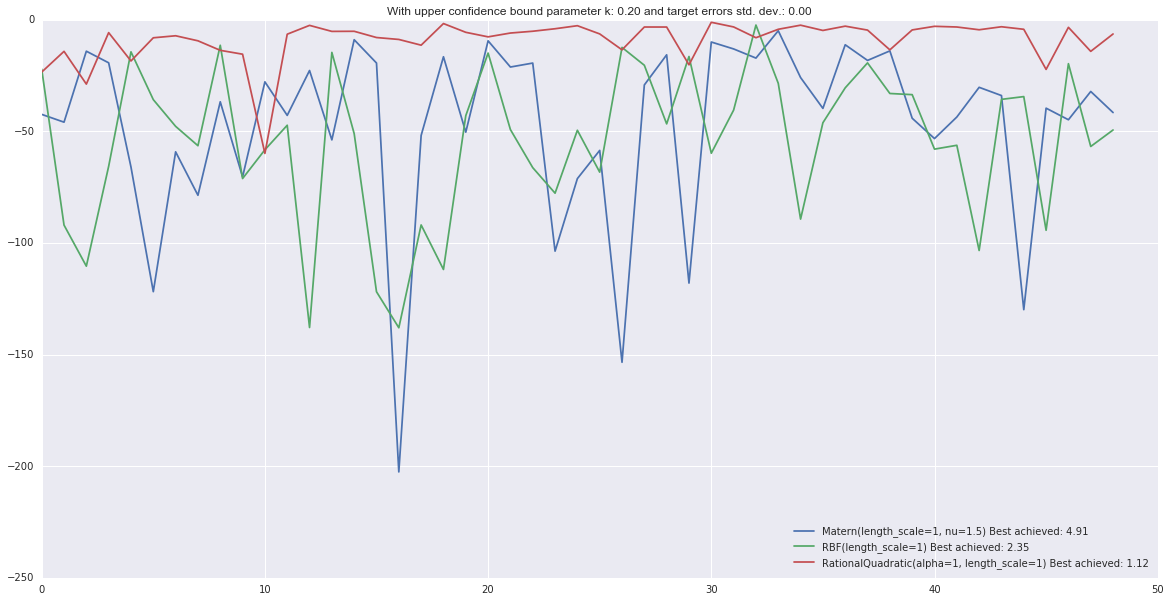

0.607429809403
0.420806479887
0.409010011015
4.11742486414
0.966785514896
0.952672302299
0.926543673116
5.34607934715
0.469416872686
0.469578619155
0.474031075657
1.91420696523


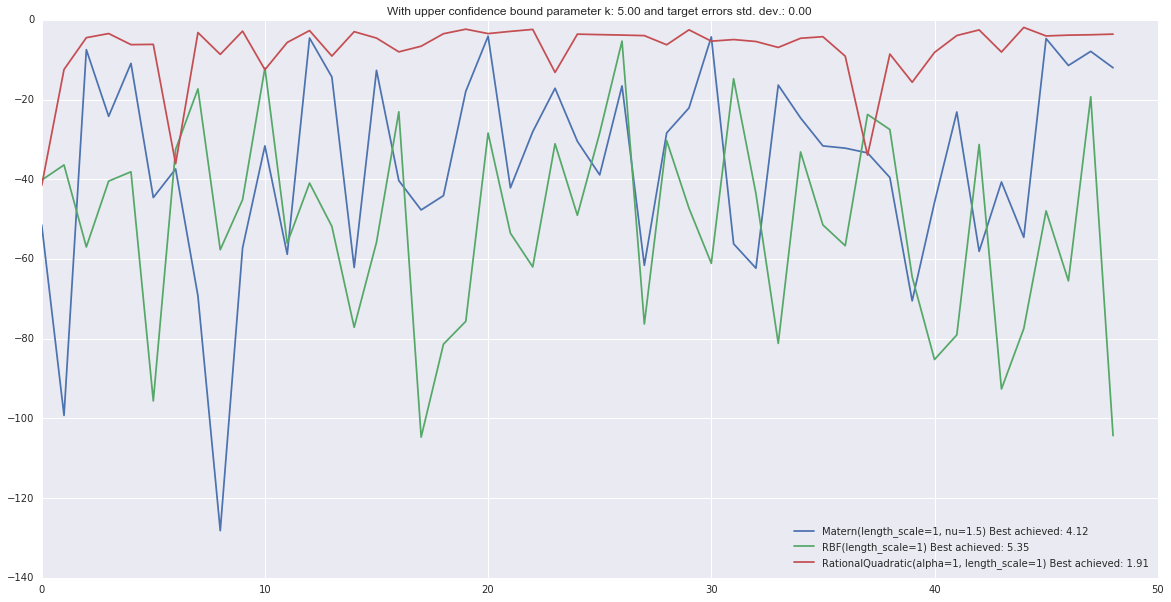

In [275]:
for k in [.2, 5]:
    for e in [.0001]:
        results = []
        for i, kernel in enumerate([Matern(), RBF(), RationalQuadratic()]):
            ro = RangeOptimizer({
                'x1': (-5., 10.),
                'x2': (0., 15.)
            }, kernel=kernel, init_observations=[
                [1, 2, brannin_hoo(np.array([1, 2]), e_std=0.1)],
                [1, 2, brannin_hoo(np.array([0, 0]), e_std=0.1)]
            ], acquisition_params={
                'k': k,
                'type': 'upper_confidence_bound'
            })
            all_scores = []
            for r in range(3):
                run_scores = []
                for t in range(50):
                    x = ro.suggest(return_dict=True)
                    y = - brannin_hoo([x['x1'], x['x2']], e_std=e) # negative to turn mimization into maximization
                    run_scores.append(y)
                    ro.update([x[fn] for fn in ro.feature_names], y)
                    
                print(-np.max(run_scores))
                all_scores.append(run_scores)
                
            avg_scores = np.stack(all_scores, axis=1).mean(axis=1)
            print(-np.max(avg_scores))
            results.append((avg_scores,str(kernel)))

        plt.figure(figsize=(20,10))
        for i, r in enumerate(results):
            plt.plot(r[0][1:], label='{} Best achieved: {:.2f}'.format(r[1], -np.max(r[0][1:])))

        plt.title('With upper confidence bound parameter k: {:.2f} and target errors std. dev.: {:.2f}'.format(k, e))
        plt.legend(loc=4)
        plt.show()

In [ ]:
for k in [.2, 5]:
    for e in [.0001]:
        results = []
        for i, kernel in enumerate([Matern(), RBF(), RationalQuadratic()]):
            ro = RangeOptimizer({
                'x1': (-5., 10.),
                'x2': (0., 15.)
            }, kernel=kernel, init_observations=[
                [1, 2, brannin_hoo(np.array([1, 2]), e_std=0.1)],
                [1, 2, brannin_hoo(np.array([0, 0]), e_std=0.1)]
            ], acquisition_params={
                'k': k,
                'type': 'upper_confidence_bound'
            })
            all_scores = []
            for r in range(3):
                run_scores = []
                for t in range(50):
                    x = ro.suggest(return_dict=True)
                    y = - brannin_hoo([x['x1'], x['x2']], e_std=e) # negative to turn mimization into maximization
                    run_scores.append(y)
                    ro.update([x[fn] for fn in ro.feature_names], y)
                    
                print(-np.max(run_scores))
                all_scores.append(run_scores)
                
            avg_scores = np.stack(all_scores, axis=1).mean(axis=1)
            print(-np.max(avg_scores))
            results.append((avg_scores,str(kernel)))

        plt.figure(figsize=(20,10))
        for i, r in enumerate(results):
            plt.plot(r[0][1:], label='{} Best achieved: {:.2f}'.format(r[1], -np.max(r[0][1:])))

        plt.title('With upper confidence bound parameter k: {:.2f} and target errors std. dev.: {:.2f}'.format(k, e))
        plt.legend(loc=4)
        plt.show()

0.46153668977
0.410711787413


/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


0.397810292753
0.435466011236
1.12629280686
0.78430310662
0.812506515979
10.5116979399
0.80717236546
0.807169678865
